## Experiments with of a diffused censored GP in BayesNewton - Spatio-temporal fake data B

### Required imports

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "4" # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = "4" # export OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = "6" # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "4" # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = "6" # export NUMEXPR_NUM_THREADS=6

In [2]:
import bayesnewton
import numpy as np
import matplotlib.pyplot as plt
import time
import objax
import jax.numpy as jnp
import math
from tqdm import tqdm
from sklearn.metrics import r2_score
from censored_diffused_GP import *
plt.rcParams.update({'font.size': 16})

LOG2PI = math.log(2 * math.pi)
INV2PI = (2 * math.pi) ** -1

### GP hyper-params

In [3]:
var_f = 1.0         # kernel variance
len_time = 1.0      # temporal lenghtscale
period = 50         # period of periodic kernel
len_space = 1.0     # spatial lenghtscale
lik_variance = 0.1  # Variance of the likelihood

sparse = False
opt_z = False  # will be set to False if sparse=False

### Create dataset

In [5]:
np.random.seed(123)

# sample station locations
num_stations = 10
station_locations = np.array([[np.random.uniform(-2,2), np.random.uniform(-2,2)] for i in range(num_stations)])

Nplot = 400
R_plot = np.repeat(station_locations[None,:], Nplot, axis=0)
t_plot = np.linspace(-20, 150, num=Nplot)

#ix_train = np.concatenate([np.arange(5, 270, 3), np.arange(300, 395, 3)], axis=0) # indices used for training
ix_train = np.arange(5, 395, 3) # indices used for training
t = t_plot[ix_train]
Nt = len(t) # lenght of each time-series
R = np.repeat(station_locations[None,:], Nt,axis=0)
print("R.shape:", R.shape)

print("t.shape:", t.shape)
print("t_plot.shape:", t_plot.shape)

if sparse:
    z1 = np.linspace(np.min(station_locations[:, 0]), np.max(station_locations[:, 0]), num=7)
    z2 = np.linspace(np.min(station_locations[:, 1]), np.max(station_locations[:, 1]), num=7)
    zA, zB = np.meshgrid(z1, z2)  # Adding additional dimension to inducing points grid
    z = np.hstack((zA.reshape(-1, 1), zB.reshape(-1, 1)))  # Flattening grid for use in kernel functions
    del z1, z2, zA, zB
else:
    z = R[0, ...]
    
#z = R[0, ...]
    
print("z.shape:", z.shape)

R.shape: (130, 10, 2)
t.shape: (130,)
t_plot.shape: (400,)
z.shape: (10, 2)


In [6]:
# 0 sends all to 1; 2 sends all to 1; 1 sends to both 0 and 2
X_diffusion = jnp.array(station_locations)

#print("----------------------- Regularized Laplacian kernel:")
#print(k_RL(X_diffusion, lengthscale=10, beta=1))

#print("----------------------- Diffusion kernel:")
#print(k_Diff(X_diffusion, lengthscale=10, beta=1))

print("----------------------- My diffusion kernel:")
#transition_matrix = compute_transition_matrix(X_diffusion, diffusion_lengthscale=0.1, sink_prob=0.01)
transition_matrix = compute_transition_matrix(X_diffusion, diffusion_lengthscale=0.1, sink_prob=0.2)
print(transition_matrix)

----------------------- My diffusion kernel:
[[ 0.00000000e+000  3.54864896e-095  8.00000000e-001  1.98365593e-077
   3.64762977e-014  1.21176653e-105  4.76848818e-035  5.31819506e-096
   3.67315138e-090  1.52440465e-024  2.00000000e-001]
 [ 3.35139300e-086  0.00000000e+000  3.59840224e-075  8.11863177e-189
   2.21437167e-016  7.99999805e-001  1.06743628e-084  1.94819916e-007
   6.50105716e-035  1.55368792e-017  2.00000000e-001]
 [ 8.00000000e-001  3.81019665e-084  0.00000000e+000  1.21484347e-041
   3.17731510e-014  7.74919070e-076  2.00293114e-067  1.81915673e-064
   1.30135045e-115  1.69426512e-010  2.00000000e-001]
 [ 1.30627919e-036  5.66096132e-157  8.00000000e-001  0.00000000e+000
   7.14930070e-070  3.20470721e-095  3.19144516e-191  2.91859918e-072
   0.00000000e+000  1.51430265e-031  2.00000000e-001]
 [ 3.40516430e-013  2.18884757e-024  2.96611242e-013  1.01349409e-109
   0.00000000e+000  3.46639834e-039  3.58304455e-032  4.20381472e-037
   2.08919147e-040  8.00000000e-001  2.

In [7]:
# model definition
kern_time0 = bayesnewton.kernels.Matern32(variance=var_f, lengthscale=50)
kern_time1 = bayesnewton.kernels.Periodic(variance=var_f, lengthscale=len_time, period=period)
kern_time = bayesnewton.kernels.Sum([kern_time0, kern_time1])
#kern_time = bayesnewton.kernels.Periodic(variance=var_f, lengthscale=len_time, period=period)
kern_space0 = bayesnewton.kernels.Matern32(variance=var_f, lengthscale=100)
kern_space1 = bayesnewton.kernels.Matern32(variance=var_f, lengthscale=100)
kern_space = bayesnewton.kernels.Separable([kern_space0, kern_space1])

kern = bayesnewton.kernels.SpatioTemporalKernel(temporal_kernel=kern_time,
                                                spatial_kernel=kern_space,
                                                z=z,
                                                sparse=sparse,
                                                opt_z=opt_z,
                                                conditional='Full')

lik = bayesnewton.likelihoods.Gaussian(variance=lik_variance)
# model = bayesnewton.models.VariationalGP(kernel=kern, likelihood=lik, X=X, Y=y)
model = bayesnewton.models.MarkovVariationalGP(kernel=kern, likelihood=lik, X=t_plot, R=R_plot, Y=np.zeros((len(t_plot),10,1)))

/Users/rodr/code/diffusion-censored-gps/BayesNewton/bayesnewton/kernels.py:444: UserWarning: You chose a non-deterministic conditional, but 'DTC' will be used because the model is not sparse
  warn("You chose a non-deterministic conditional, but \'DTC\' will be used because the model is not sparse")


f.shape: (400, 10, 1)
y.shape: (130, 10, 1)


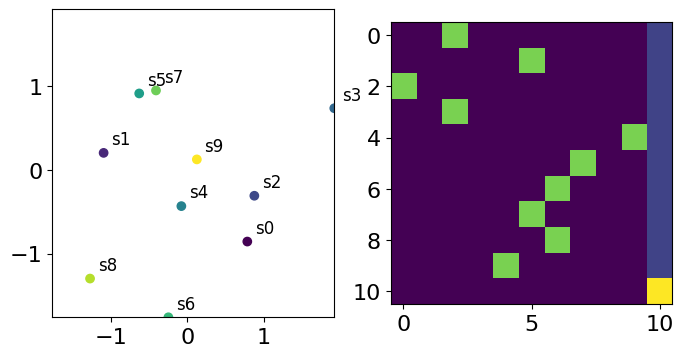

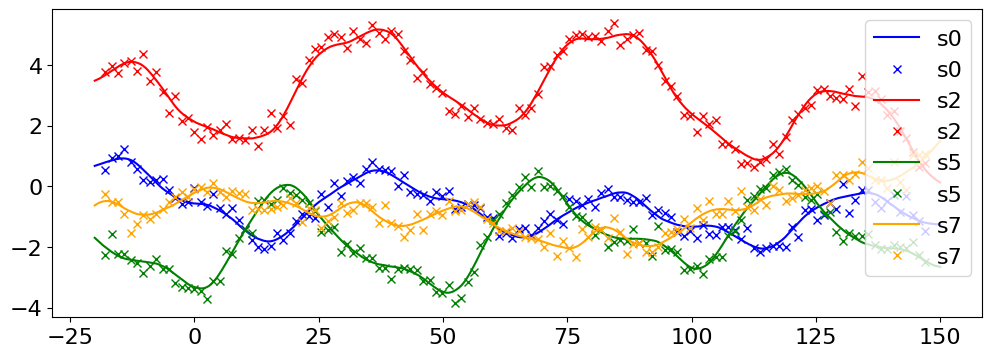

In [8]:
f_plot = model.prior_sample(seed=1)[0]
print("f.shape:", f_plot.shape)
noise_cov = 0.05*np.eye(num_stations)
noise = np.linalg.cholesky(noise_cov)[None] @ np.random.multivariate_normal(np.zeros(num_stations), np.eye(num_stations), f_plot.shape[0])[..., None]
y_plot = f_plot + noise
f = f_plot[ix_train]
y = y_plot[ix_train]
print("y.shape:", y.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.scatter(station_locations[:,0], station_locations[:,1], c=range(10))
for i in range(num_stations):
    ax1.text(station_locations[i,0] + 0.1, station_locations[i,1] + 0.1, "s%d" % (i,), fontsize=12)
ax1.set_xlim([np.min(station_locations),np.max(station_locations)])
ax1.set_ylim([np.min(station_locations),np.max(station_locations)])
ax2.imshow(transition_matrix)
plt.show()

plt.figure(figsize=(12,4))
plt.plot(t_plot, f_plot[:,0,0], 'b-', label="s0") # station s0
plt.plot(t, y[:,0,0], 'bx', label="s0") 
plt.plot(t_plot, f_plot[:,2,0], 'r-', label="s2") # station s2 should be close to station s0
plt.plot(t, y[:,2,0], 'rx', label="s2") 
plt.plot(t_plot, f_plot[:,5,0], 'g-', label="s5") # station s5
plt.plot(t, y[:,5,0], 'gx', label="s5") 
plt.plot(t_plot, f_plot[:,7,0], 'orange', label="s7") # station s7 should be far apart from station s0 and s2
plt.plot(t, y[:,7,0], "x", color="orange", label="s7") 
plt.legend()
plt.show()

-0.28171654183329187 0.5333333333333333


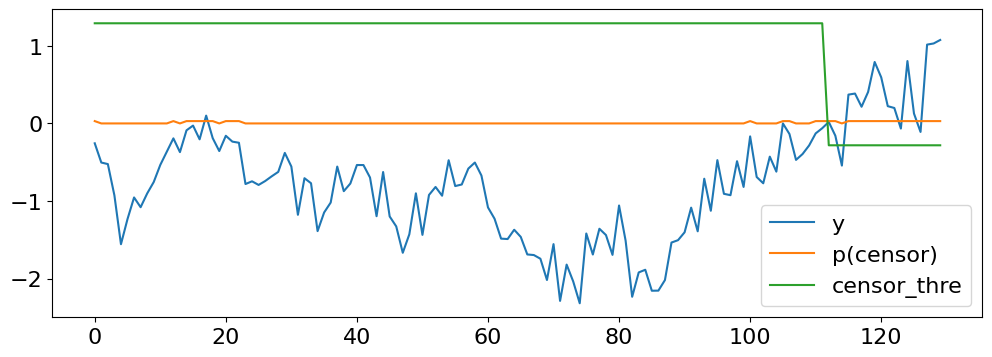

In [9]:
import scipy

def censor_time_series(ts, plot=False):
    #censor_value = 1.5
    censor_value = float(max(ts)-0.4*(max(ts)-min(ts)))
    #censor_value = float(0.5*max(ts)/(max(ts)-min(ts)))
    #censor_value = float(0.8*max(ts))
    print(censor_value, 0.8*2/3)
    #censor_probs = 0.2*scipy.special.expit(np.log(0.1+np.maximum(ts-0.,0))) # probabilities of entering censor state at each time step t
    censor_probs = 0.03*(ts > censor_value) # probabilities of entering censor state at each time step t
    exit_prob = 0.1 # probability of exiting censor state

    censor_state = False
    censor_thre = 1.2*float(max(ts))*np.ones(len(ts))
    for t in range(len(ts)):
        if censor_state:
            if np.random.rand() < exit_prob:
                # exit censor state
                censor_state = False
            else:
                censor_thre[t] = censor_value # apply censoring
        else:
            if ts[t] > censor_value and np.random.rand() < censor_probs[t]:
                # enter censor state
                censor_state = True
                #censor_value = ts[t+1] # dynamic censor value
                censor_thre[t] = censor_value

    if plot:
        plt.figure(figsize=(12,4))
        plt.plot(ts, label='y')
        plt.plot(censor_probs, label='p(censor)')
        plt.plot(censor_thre, label='censor_thre')
        plt.legend()
        plt.show()
    
    return censor_thre

# demo of censoring process with a single time series
censor_thre = censor_time_series(y[:,7,0], plot=True)

In [10]:
# apply censoring function to all time series to obtain censoring thresholds for all of them
censoring_thre_plot = []
for station in range(num_stations):
    censoring_thre_plot.append(censor_time_series(y_plot[:,station,0]))
    
censoring_thre_plot = np.array(censoring_thre_plot).transpose()[...,None]
print(censoring_thre_plot.shape)

censoring_thre = censoring_thre_plot[ix_train]
print(censoring_thre.shape)

-0.15235342539563046 0.5333333333333333
1.1519022122662168 0.5333333333333333
3.250604049497452 0.5333333333333333
0.14689560618515873 0.5333333333333333
0.5373163221124386 0.5333333333333333
-1.1108238966153283 0.5333333333333333
2.100859571952821 0.5333333333333333
0.06589374876940957 0.5333333333333333
-1.6441924976264914 0.5333333333333333
-0.21631139489304596 0.5333333333333333
(400, 10, 1)
(130, 10, 1)


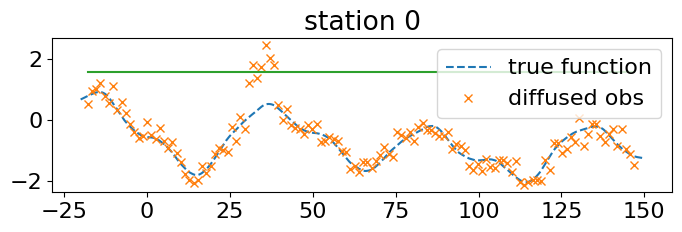

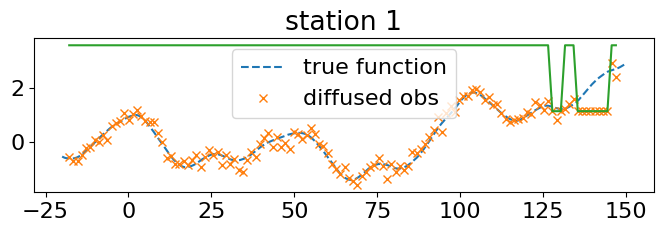

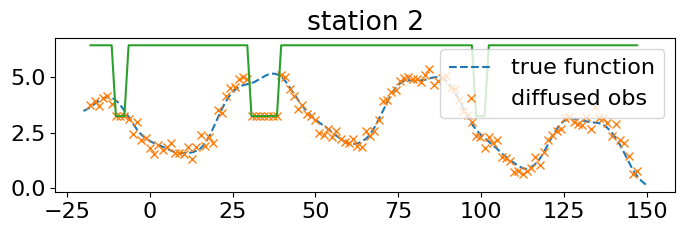

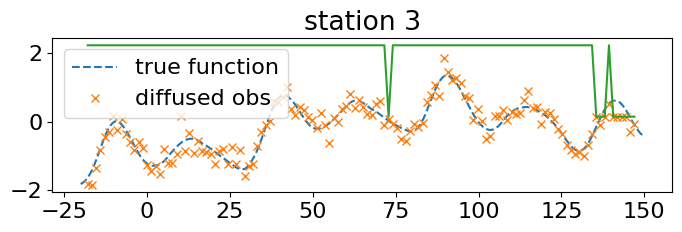

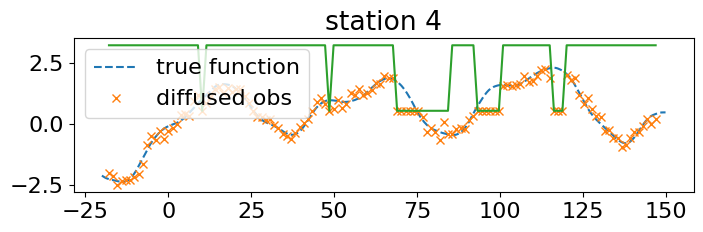

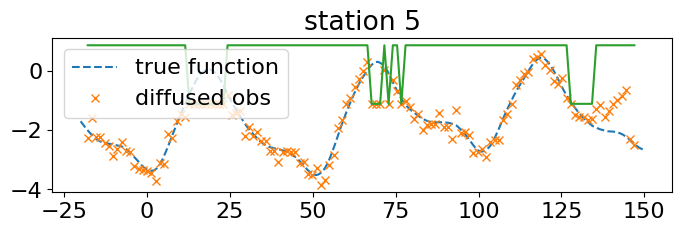

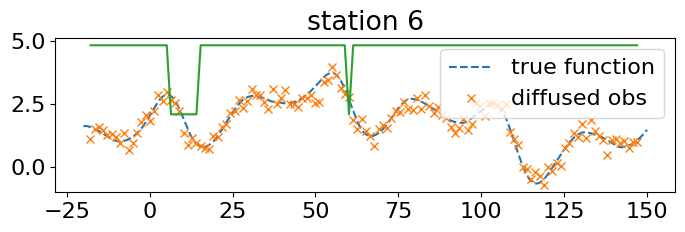

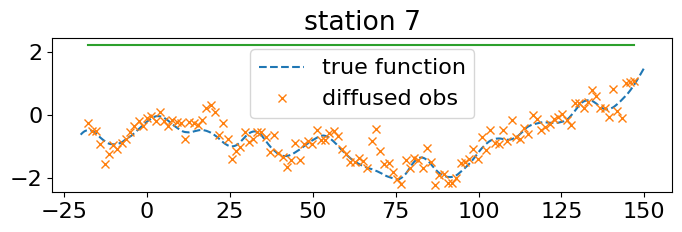

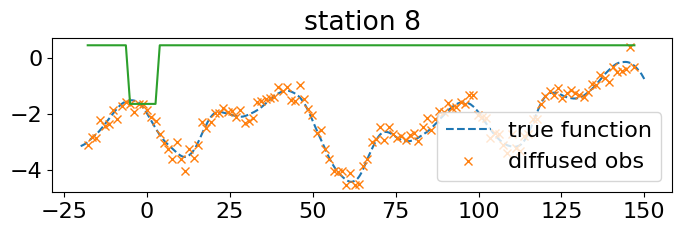

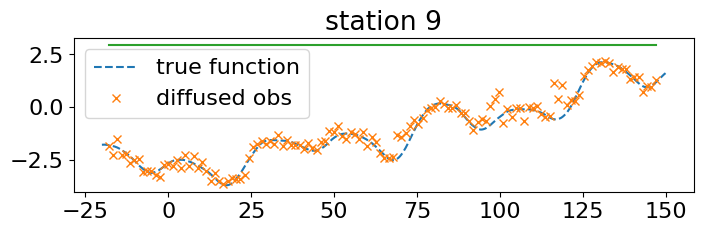

In [11]:
# execute diffusion process
censoring_indicator = y > censoring_thre
y_cens = np.where(censoring_indicator, censoring_thre, y)
y_excess = y - y_cens
y_excess_diffused = y_excess[:,:,0] @ transition_matrix[:num_stations,:]
y_diffused = y_cens.copy()[:,:,0] + y_excess_diffused[:,:num_stations]
y_diffused = y_diffused[...,None]

for i in range(num_stations):
    plt.figure(figsize=(8,2))
    plt.plot(t_plot, f_plot[:,i], "--", label="true function")
    #plt.plot(y_excess[:,i], "x", label="censored obs")
    plt.plot(t, y_diffused[:,i], "x", label="diffused obs")
    plt.plot(t, censoring_thre[:,i])
    plt.legend()
    plt.title("station %i" % (i,))
    plt.show()

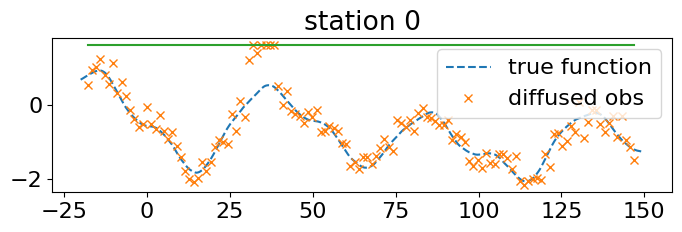

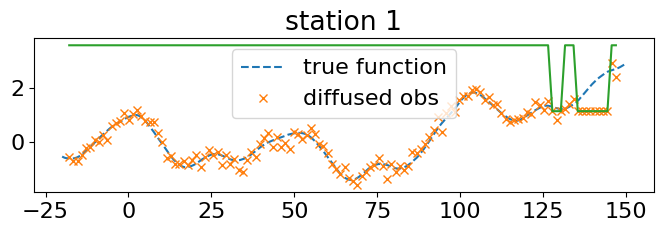

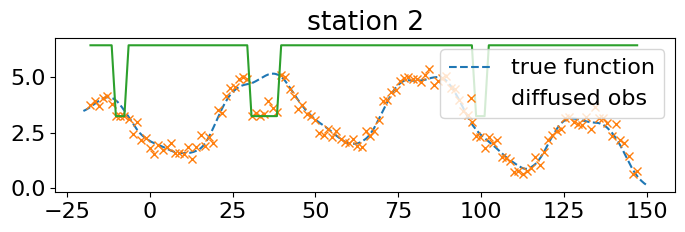

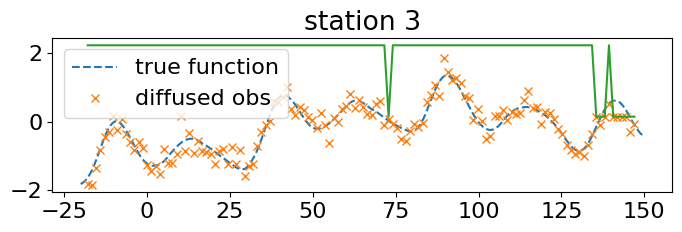

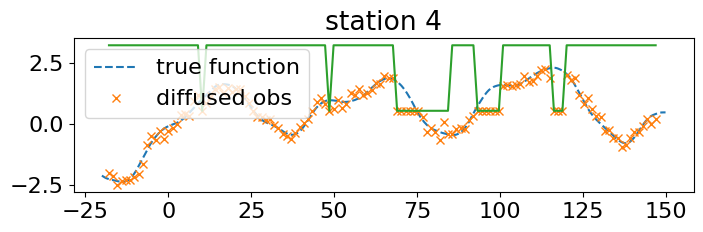

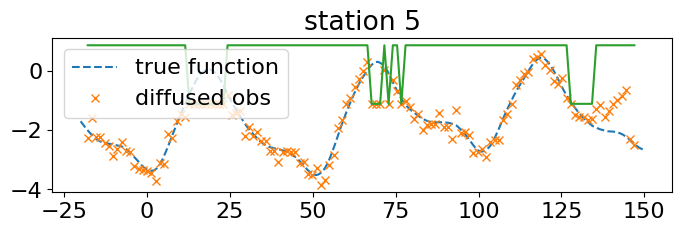

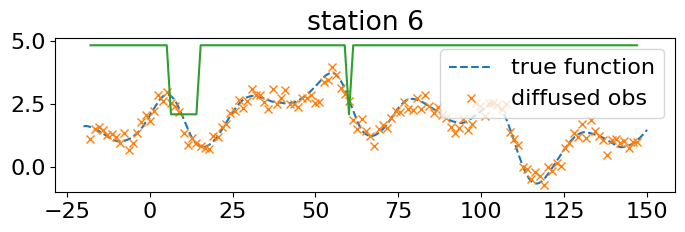

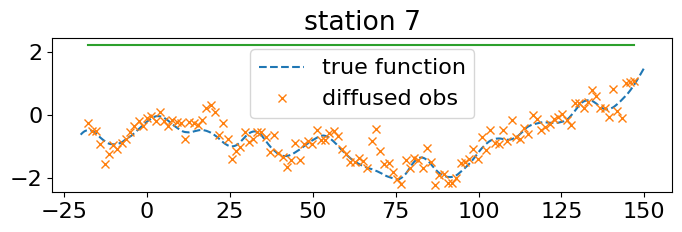

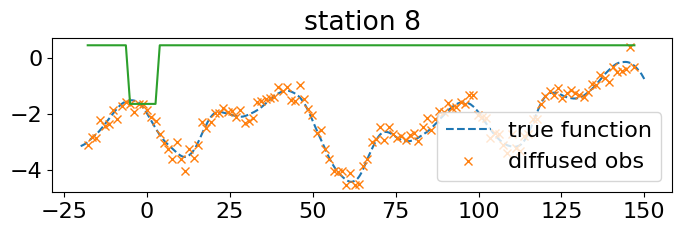

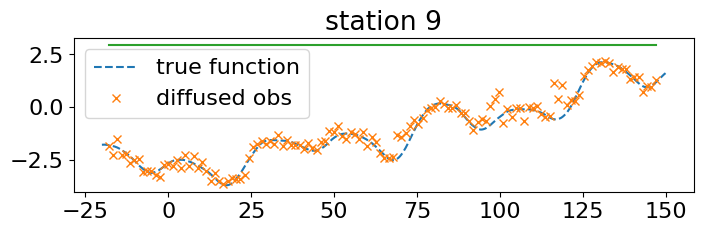

In [12]:
# execute diffusion process AGAIN!!
censoring_indicator2 = y_diffused > censoring_thre
y_cens = np.where(censoring_indicator2, censoring_thre, y_diffused)
y_excess = y_diffused - y_cens
y_excess_diffused = y_excess[:,:,0] @ transition_matrix[:num_stations,:]
y_diffused = y_cens.copy()[:,:,0] + y_excess_diffused[:,:num_stations]
y_diffused = y_diffused[...,None]

for i in range(num_stations):
    plt.figure(figsize=(8,2))
    plt.plot(t_plot, f_plot[:,i], "--", label="true function")
    #plt.plot(y_excess[:,i], "x", label="censored obs")
    plt.plot(t, y_diffused[:,i], "x", label="diffused obs")
    plt.plot(t, censoring_thre[:,i])
    plt.legend()
    plt.title("station %i" % (i,))
    plt.show()

### Re-usable code blocks for training and evaluating models

In [13]:
def train_model(model, iters=150, lr_newton = 1., lr_adam = 0.1):
    opt_hypers = objax.optimizer.Adam(model.vars())
    energy = objax.GradValues(model.energy, model.vars())

    @objax.Function.with_vars(model.vars() + opt_hypers.vars())
    def train_op():
        model.inference(lr=lr_newton)  # perform inference and update variational params
        dE, E = energy()  # compute energy and its gradients w.r.t. hypers
        opt_hypers(lr_adam, dE)
        return E


    train_op = objax.Jit(train_op)

    t0 = time.time()
    loop = tqdm(range(iters))
    losses = []
    for i in loop:
        loss = train_op()
        #if not i % 20:
        #    print('iter %2d, energy: %1.4f' % (i, loss[0]))
        loop.set_description(f"Iter [{i}/{iters}]")
        loop.set_postfix(loss=loss[0])
        losses.append(loss[0])
    t1 = time.time()
    print('optimisation time: %2.2f secs' % (t1-t0))
    
    plt.figure(1, figsize=(6, 4))
    plt.plot(losses, label='training energy')
    plt.title("Training energy")
    plt.show()
    
    return model
    
in_censoring = False
censoring_start = t[0]
censoring_ranges = []
for i in range(len(censoring_indicator)):
    if in_censoring:
        if not np.any(censoring_indicator[i,[0,2,5]]) and not np.any(censoring_indicator2[i,[0,2,5]]):
            censoring_ranges.append([censoring_start, t[i]])
            in_censoring = False
    else:
        if np.any(censoring_indicator[i,[0,2,5]]) or np.any(censoring_indicator2[i,[0,2,5]]):
            censoring_start = t[i]
            in_censoring = True

def eval_model(model, t, R, extra, y, y_diffused, x_test, R_test, extra_test, y_test):
    # evaluate on train set 
    posterior_mean_train, posterior_var_train = model.predict(X=t, R=R)
    nlpd_train_diff = model.negative_log_predictive_density(X=t, R=R, extra=extra, Y=y_diffused)
    nlpd_train = model.negative_log_predictive_density(X=t, R=R, extra=extra, Y=y)
    rmse_train = np.sqrt(np.mean((y[:,:posterior_mean_train.shape[1],0] - posterior_mean_train)**2))
    r2_train = r2_score(np.array(y[:,:posterior_mean_train.shape[1],0]), np.array(posterior_mean_train)) 
    rmse_f = np.sqrt(np.mean((f[:,:posterior_mean_train.shape[1],0] - posterior_mean_train)**2))
    print('[trainset] nlpd (diff): %2.3f\tnlpd (true): %2.3f\trmse (true): %2.3f\tr2 (true): %2.3f\trmse (func): %2.3f' % (nlpd_train_diff, nlpd_train, rmse_train, r2_train, rmse_f))
    
    # evaluate on test set 
    posterior_mean_test, posterior_var_test = model.predict(X=x_test, R=R_test)
    nlpd_test = model.negative_log_predictive_density(X=x_test, R=R_test, extra=extra_test, Y=y_test)
    rmse_test = np.sqrt(np.mean((y_test[:,:posterior_mean_test.shape[1],0] - posterior_mean_test)**2))
    r2_test = r2_score(np.array(y_test[:,:posterior_mean_test.shape[1],0]), np.array(posterior_mean_test))
    rmse_fplot = np.sqrt(np.mean((f_plot[:,:posterior_mean_test.shape[1],0] - posterior_mean_test)**2))
    print('[testset] \t\t\tnlpd (true): %2.3f\trmse (true): %2.3f\tr2 (true): %2.3f\trmse (func): %2.3f' % (nlpd_test, rmse_test, r2_test, rmse_fplot))

    # make plots with predictions
    posterior_mean, posterior_var = model.predict_y(X=t_plot, R=R_plot)
    lb = posterior_mean - 1.96 * posterior_var ** 0.5
    ub = posterior_mean + 1.96 * posterior_var ** 0.5

    plt.figure(1, figsize=(12, 4))
    plt.clf()
    for pair in censoring_ranges:
        plt.axvspan(pair[0], pair[1], alpha=0.15, color='yellow')
    plt.plot(t, y_diffused[:, 0], 'bx', label='observed')
    plt.plot(t, y_diffused[:, 2], 'rx')
    plt.plot(t, y_diffused[:, 5], 'gx')
    plt.plot(t, f[:, 0], 'b--', label='true')
    plt.plot(t, f[:, 2], 'r--')
    plt.plot(t, f[:, 5], 'g--')
    # plt.plot(x_test, y_test, 'r.', alpha=0.4, label='test observations')
    plt.plot(t_plot, posterior_mean[:, 0], 'b', label='inferred')
    plt.plot(t_plot, posterior_mean[:, 2], 'r')
    plt.plot(t_plot, posterior_mean[:, 5], 'g')
    plt.fill_between(t_plot, lb[:, 0], ub[:, 0], color='b', alpha=0.05)
    plt.fill_between(t_plot, lb[:, 2], ub[:, 2], color='r', alpha=0.05)
    plt.fill_between(t_plot, lb[:, 5], ub[:, 5], color='g', alpha=0.05)
    plt.xlim([t[1], t[-1]])
    plt.ylim(-4,7.5)
    if hasattr(model, 'Z'):
        plt.plot(model.Z.value[:, 0], -2 * np.ones_like(model.Z.value[:, 0]), 'b^', markersize=5)
    plt.legend(loc="upper right", ncol=3)
    plt.xlabel('$t$')
    plt.show()

### Fit Gaussian GP to true data

Iter [4999/5000]: 100%|██████████| 5000/5000 [1:22:54<00:00,  1.01it/s, loss=262.41926182582677]

optimisation time: 4974.30 secs


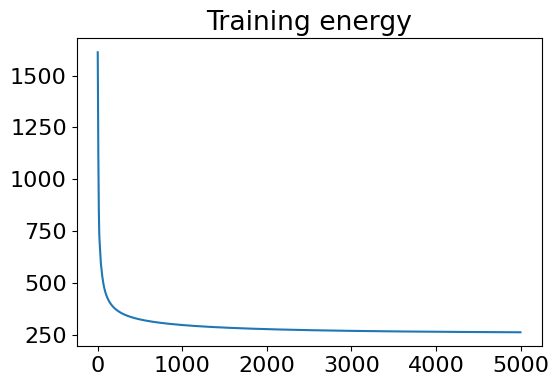

In [16]:
# model definition
# kern_time = bayesnewton.kernels.Matern32(variance=var_f, lengthscale=len_time)
kern_time0 = bayesnewton.kernels.Matern32(variance=var_f, lengthscale=len_time)
kern_time1 = bayesnewton.kernels.Periodic(variance=var_f, lengthscale=len_time, period=period, order=3)
kern_time = bayesnewton.kernels.Sum([kern_time0, kern_time1])
#kern_time = bayesnewton.kernels.Periodic(variance=var_f, lengthscale=len_time, period=period, order=3)
kern_space0 = bayesnewton.kernels.Matern32(variance=var_f, lengthscale=len_space)
kern_space1 = bayesnewton.kernels.Matern32(variance=var_f, lengthscale=len_space)
kern_space = bayesnewton.kernels.Separable([kern_space0, kern_space1])

kern = bayesnewton.kernels.SpatioTemporalKernel(temporal_kernel=kern_time,
                                                spatial_kernel=kern_space,
                                                z=z,
                                                sparse=sparse,
                                                opt_z=opt_z,
                                                conditional='DTC')

lik = MyGaussian(variance=lik_variance)
model = bayesnewton.models.MarkovVariationalGP(kernel=kern, likelihood=lik, X=t, R=R, Y=y)

# alternative version (slower)
# targets = y.reshape(Nt*num_stations,1)
# targets.shape
# print(targets.shape)
# inputs = np.concatenate([t[...,None].repeat(num_stations, axis=1)[...,None], R], axis=2).reshape(Nt*num_stations,3)
# inputs.shape
# print(inputs.shape)
# model = bayesnewton.models.VariationalGP(kernel=kern, likelihood=lik, X=inputs, Y=targets)

model = train_model(model, iters=5000)

[trainset] nlpd (diff): 0.407	nlpd (true): -0.094	rmse (true): 0.239	r2 (true): 0.937	rmse (func): 0.144
[testset] 			nlpd (true): -0.031	rmse (true): 0.273	r2 (true): 0.924	rmse (func): 0.178


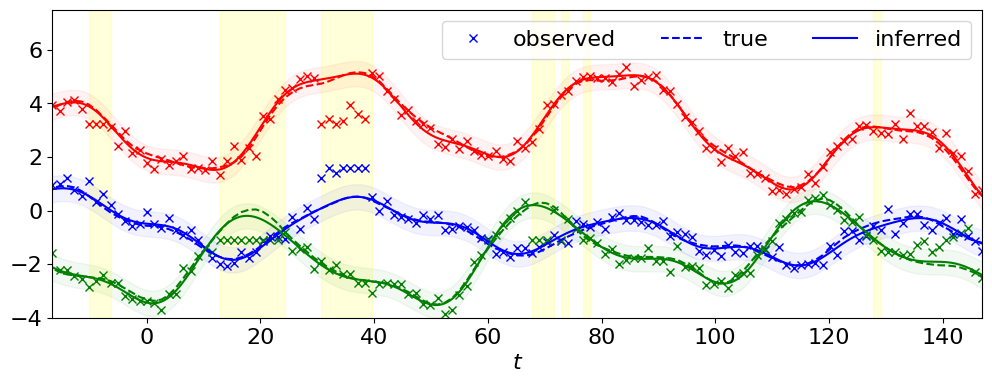

In [17]:
eval_model(model, t, R, None, y, y_diffused, t_plot, R_plot, None, y_plot)

### Fit Gaussian GP to diffused data

Iter [4999/5000]: 100%|██████████| 5000/5000 [1:31:51<00:00,  1.10s/it, loss=495.8593849978556] 

optimisation time: 5511.11 secs


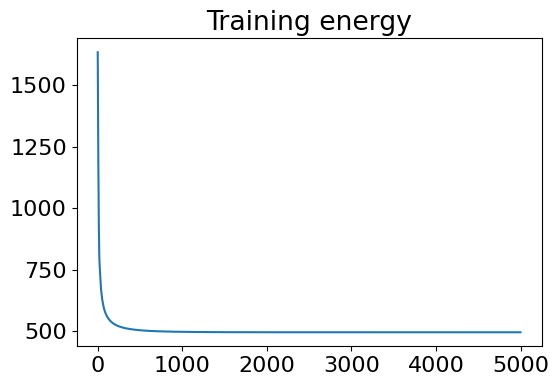

In [18]:
# model definition
# kern_time = bayesnewton.kernels.Matern32(variance=var_f, lengthscale=len_time)
kern_time0 = bayesnewton.kernels.Matern32(variance=var_f, lengthscale=len_time)
kern_time1 = bayesnewton.kernels.Periodic(variance=var_f, lengthscale=len_time, period=period, order=3)
kern_time = bayesnewton.kernels.Sum([kern_time0, kern_time1])
#kern_time = bayesnewton.kernels.Periodic(variance=var_f, lengthscale=len_time, period=period, order=3)
kern_space0 = bayesnewton.kernels.Matern32(variance=var_f, lengthscale=len_space)
kern_space1 = bayesnewton.kernels.Matern32(variance=var_f, lengthscale=len_space)
kern_space = bayesnewton.kernels.Separable([kern_space0, kern_space1])

kern = bayesnewton.kernels.SpatioTemporalKernel(temporal_kernel=kern_time,
                                                spatial_kernel=kern_space,
                                                z=z,
                                                sparse=sparse,
                                                opt_z=opt_z,
                                                conditional='DTC')

lik = MyGaussian(variance=lik_variance)
model = bayesnewton.models.MarkovVariationalGP(kernel=kern, likelihood=lik, X=t, R=R, Y=y_diffused)

model = train_model(model, iters=5000)

[trainset] nlpd (diff): -0.016	nlpd (true): 0.188	rmse (true): 0.315	r2 (true): 0.900	rmse (func): 0.272
[testset] 			nlpd (true): 0.285	rmse (true): 0.358	r2 (true): 0.877	rmse (func): 0.300


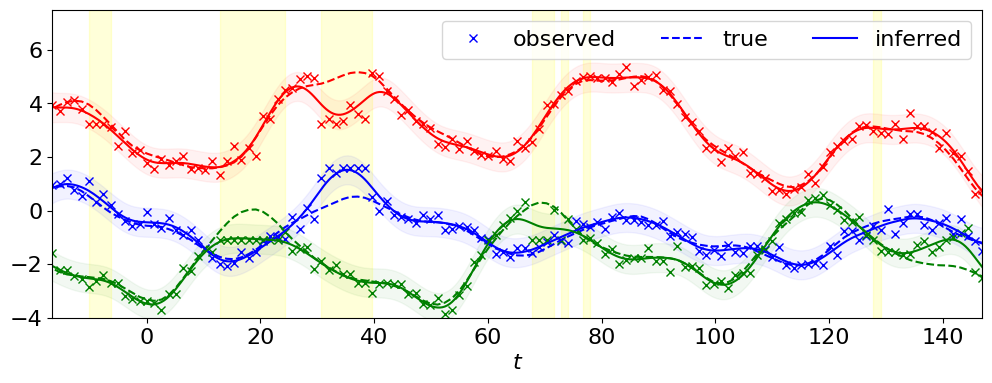

In [19]:
eval_model(model, t, R, None, y, y_diffused, t_plot, R_plot, None, y_plot)

### Fit Censored Gaussian GP to diffused data

Iter [4999/5000]: 100%|██████████| 5000/5000 [1:22:23<00:00,  1.01it/s, loss=432.6030803021049] 

optimisation time: 4943.69 secs


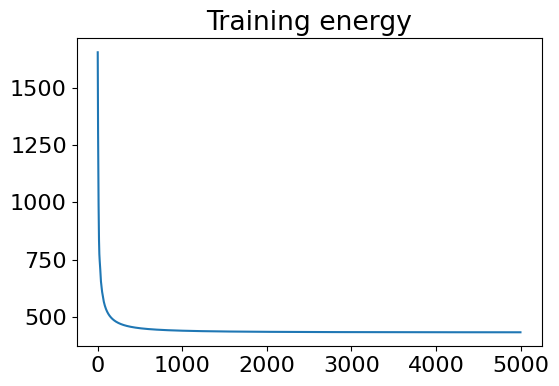

In [20]:
# model definition
# kern_time = bayesnewton.kernels.Matern32(variance=var_f, lengthscale=len_time)
kern_time0 = bayesnewton.kernels.Matern32(variance=var_f, lengthscale=len_time)
kern_time1 = bayesnewton.kernels.Periodic(variance=var_f, lengthscale=len_time, period=period, order=3)
kern_time = bayesnewton.kernels.Sum([kern_time0, kern_time1])
#kern_time = bayesnewton.kernels.Periodic(variance=var_f, lengthscale=len_time, period=period, order=3)
kern_space0 = bayesnewton.kernels.Matern32(variance=var_f, lengthscale=len_space)
kern_space1 = bayesnewton.kernels.Matern32(variance=var_f, lengthscale=len_space)
kern_space = bayesnewton.kernels.Separable([kern_space0, kern_space1])

kern = bayesnewton.kernels.SpatioTemporalKernel(temporal_kernel=kern_time,
                                                spatial_kernel=kern_space,
                                                z=z,
                                                sparse=sparse,
                                                opt_z=opt_z,
                                                conditional='DTC')

lik = MyCensoredGaussian(variance=lik_variance)
#lik = MyGaussian(variance=lik_variance)
#model = bayesnewton.models.MarkovVariationalGP(kernel=kern, likelihood=lik, X=t, R=R, Y=np.concatenate([y_diffused, censoring_thre], axis=2))
model = bayesnewton.models.MarkovVariationalGP(kernel=kern, likelihood=lik, X=t, R=R, Y=y_diffused, extra=jnp.array(censoring_thre))
#model = bayesnewton.models.MarkovVariationalGP(kernel=kern, likelihood=lik, X=t, R=R, Y=y_diffused)

model = train_model(model, iters=5000)

[trainset] nlpd (diff): -0.003	nlpd (true): 0.064	rmse (true): 0.280	r2 (true): 0.916	rmse (func): 0.216
[testset] 			nlpd (true): 0.140	rmse (true): 0.318	r2 (true): 0.899	rmse (func): 0.246


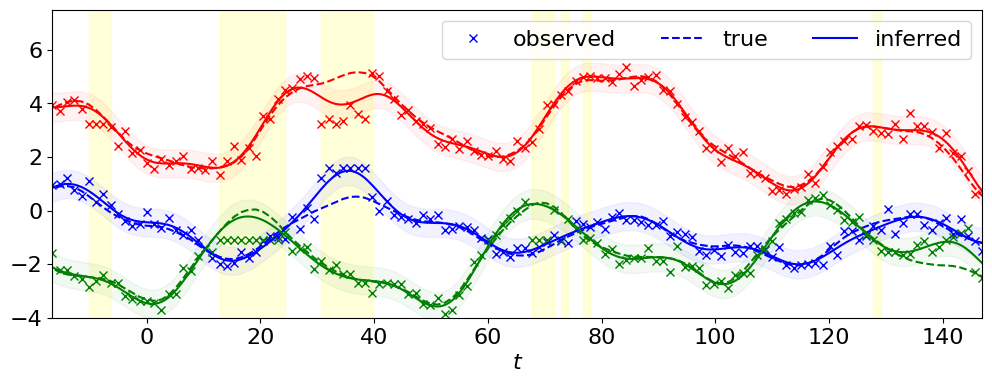

In [21]:
eval_model(model, t, R, jnp.array(censoring_thre), y, y_diffused, t_plot, R_plot, jnp.array(censoring_thre_plot), y_plot)

### Fit Diffused Censored Gaussian GP to diffused data - D

Iter [4999/5000]: 100%|██████████| 5000/5000 [1:12:35<00:00,  1.15it/s, loss=340.31314940036054]


optimisation time: 4355.62 secs


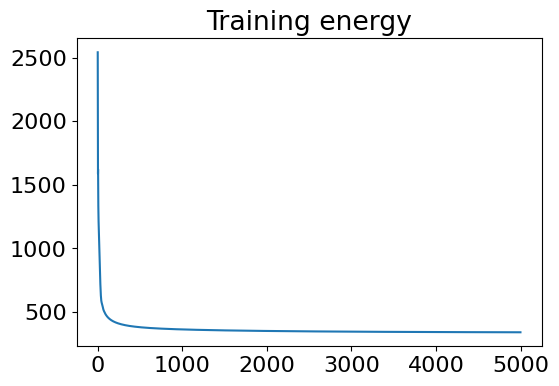

In [22]:
# model definition
# kern_time = bayesnewton.kernels.Matern32(variance=var_f, lengthscale=len_time)
kern_time0 = bayesnewton.kernels.Matern32(variance=var_f, lengthscale=len_time)
kern_time1 = bayesnewton.kernels.Periodic(variance=var_f, lengthscale=len_time, period=period, order=3)
kern_time = bayesnewton.kernels.Sum([kern_time0, kern_time1])
#kern_time = bayesnewton.kernels.Periodic(variance=var_f, lengthscale=len_time, period=period, order=3)
kern_space0 = bayesnewton.kernels.Matern32(variance=var_f, lengthscale=len_space)
kern_space1 = bayesnewton.kernels.Matern32(variance=var_f, lengthscale=len_space)
kern_space = bayesnewton.kernels.Separable([kern_space0, kern_space1])

kern = bayesnewton.kernels.SpatioTemporalKernel(temporal_kernel=kern_time,
                                                spatial_kernel=kern_space,
                                                z=z,
                                                sparse=sparse,
                                                opt_z=opt_z,
                                                conditional='DTC')

lik = MyDiffusedCensoredGaussianD(X_diffusion=X_diffusion, 
                                diffusion_steps=1,
                                diffusion_lengthscale=.1,
                                diffusion_variance=1.,
                                sink_prob=0.2,
                                fix_diffusion=True,
                                variance=lik_variance)
#lik = MyGaussian(variance=lik_variance)
#model = bayesnewton.models.MarkovVariationalGP(kernel=kern, likelihood=lik, X=t, R=R, Y=np.concatenate([y_diffused, censoring_thre], axis=2))
model = bayesnewton.models.MarkovVariationalGP(kernel=kern, likelihood=lik, X=t, R=R, Y=y_diffused, extra=jnp.array(censoring_thre))
#model = bayesnewton.models.MarkovVariationalGP(kernel=kern, likelihood=lik, X=t, R=R, Y=y_diffused)

model = train_model(model, iters = 5000) # this works better than the fancy LRs below
#model = train_model(model, iters=1000, lr_newton=0.1, lr_adam=0.01) # in this case, this LR made things worse!!

[trainset] nlpd (diff): 0.112	nlpd (true): -0.044	rmse (true): 0.249	r2 (true): 0.934	rmse (func): 0.163
[testset] 			nlpd (true): 0.020	rmse (true): 0.282	r2 (true): 0.920	rmse (func): 0.193


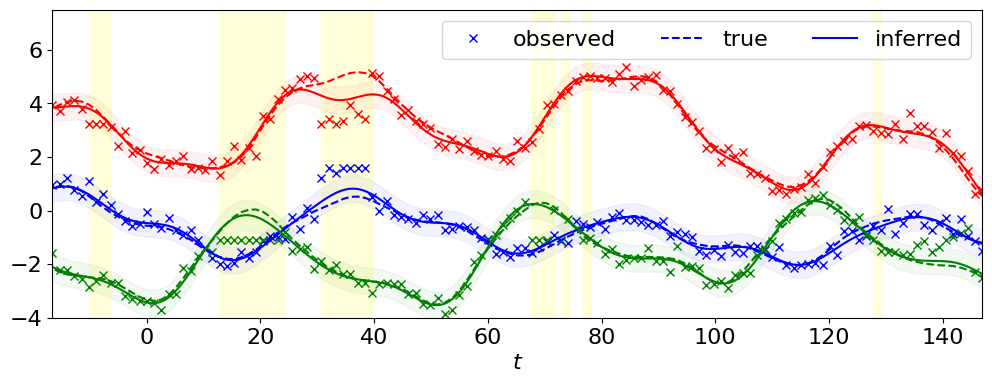

In [23]:
eval_model(model, t, R, jnp.array(censoring_thre), y, y_diffused, t_plot, R_plot, jnp.array(censoring_thre_plot), y_plot)

Iter [4999/5000]: 100%|██████████| 5000/5000 [26:45<00:00,  3.11it/s, loss=397.58392844744276]

optimisation time: 1605.63 secs


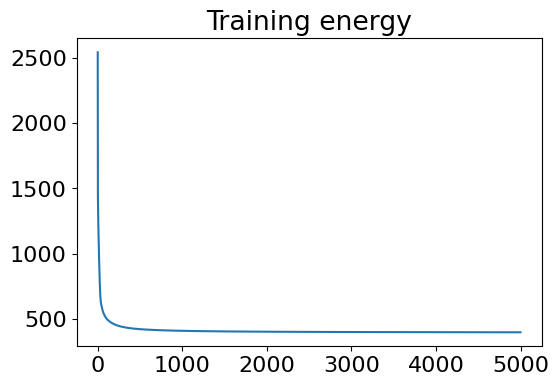

In [24]:
# model definition
# kern_time = bayesnewton.kernels.Matern32(variance=var_f, lengthscale=len_time)
kern_time0 = bayesnewton.kernels.Matern32(variance=var_f, lengthscale=len_time)
kern_time1 = bayesnewton.kernels.Periodic(variance=var_f, lengthscale=len_time, period=period, order=3)
kern_time = bayesnewton.kernels.Sum([kern_time0, kern_time1])
#kern_time = bayesnewton.kernels.Periodic(variance=var_f, lengthscale=len_time, period=period, order=3)
kern_space0 = bayesnewton.kernels.Matern32(variance=var_f, lengthscale=len_space)
kern_space1 = bayesnewton.kernels.Matern32(variance=var_f, lengthscale=len_space)
kern_space = bayesnewton.kernels.Separable([kern_space0, kern_space1])

kern = bayesnewton.kernels.SpatioTemporalKernel(temporal_kernel=kern_time,
                                                spatial_kernel=kern_space,
                                                z=z,
                                                sparse=sparse,
                                                opt_z=opt_z,
                                                conditional='DTC')

lik = MyDiffusedCensoredGaussianD(X_diffusion=X_diffusion, 
                                diffusion_steps=1,
                                diffusion_lengthscale=.1,
                                diffusion_variance=1.,
                                sink_prob=0.2,
                                fix_diffusion=False,
                                variance=lik_variance)
#lik = MyGaussian(variance=lik_variance)
#model = bayesnewton.models.MarkovVariationalGP(kernel=kern, likelihood=lik, X=t, R=R, Y=np.concatenate([y_diffused, censoring_thre], axis=2))
model = bayesnewton.models.MarkovVariationalGP(kernel=kern, likelihood=lik, X=t, R=R, Y=y_diffused, extra=jnp.array(censoring_thre))
#model = bayesnewton.models.MarkovVariationalGP(kernel=kern, likelihood=lik, X=t, R=R, Y=y_diffused)

model = train_model(model, iters = 5000) # this works better than the fancy LRs below
#model = train_model(model, iters=1000, lr_newton=0.1, lr_adam=0.01) # in this case, this LR made things worse!!

[trainset] nlpd (diff): 0.027	nlpd (true): 0.016	rmse (true): 0.266	r2 (true): 0.925	rmse (func): 0.193
[testset] 			nlpd (true): 0.088	rmse (true): 0.302	r2 (true): 0.909	rmse (func): 0.223


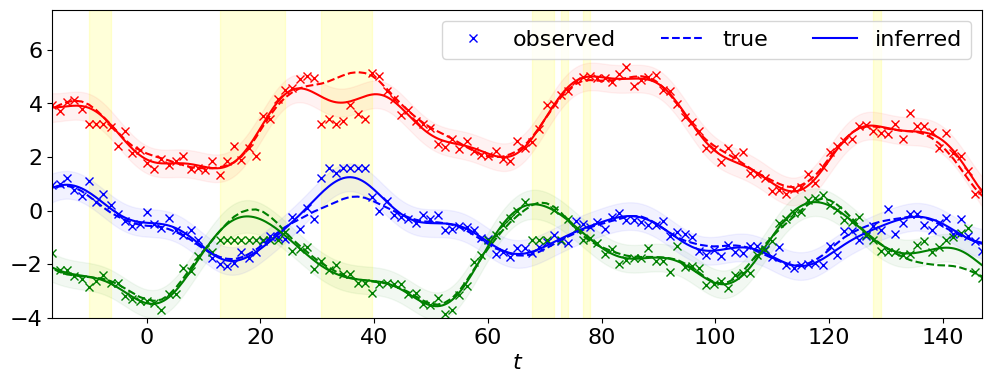

In [25]:
eval_model(model, t, R, jnp.array(censoring_thre), y, y_diffused, t_plot, R_plot, jnp.array(censoring_thre_plot), y_plot)

### Multi-step version of diffusion - D

Iter [9999/10000]: 100%|██████████| 10000/10000 [2:49:15<00:00,  1.02s/it, loss=339.45496713181115] 


optimisation time: 10155.92 secs


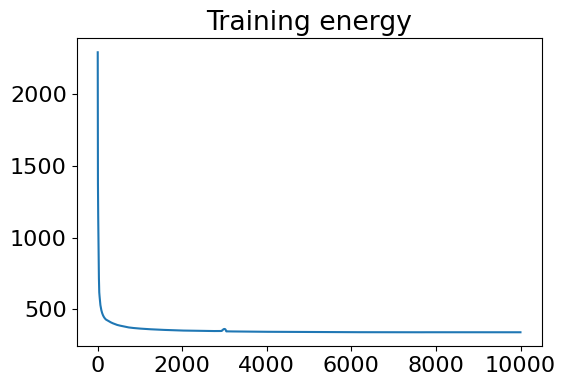

In [29]:
# model definition
# kern_time = bayesnewton.kernels.Matern32(variance=var_f, lengthscale=len_time)
kern_time0 = bayesnewton.kernels.Matern32(variance=var_f, lengthscale=len_time)
kern_time1 = bayesnewton.kernels.Periodic(variance=var_f, lengthscale=len_time, period=period, order=3)
kern_time = bayesnewton.kernels.Sum([kern_time0, kern_time1])
#kern_time = bayesnewton.kernels.Periodic(variance=var_f, lengthscale=len_time, period=period, order=3)
kern_space0 = bayesnewton.kernels.Matern32(variance=var_f, lengthscale=len_space)
kern_space1 = bayesnewton.kernels.Matern32(variance=var_f, lengthscale=len_space)
kern_space = bayesnewton.kernels.Separable([kern_space0, kern_space1])

kern = bayesnewton.kernels.SpatioTemporalKernel(temporal_kernel=kern_time,
                                                spatial_kernel=kern_space,
                                                z=z,
                                                sparse=sparse,
                                                opt_z=opt_z,
                                                conditional='DTC')

lik = MyDiffusedCensoredGaussianD(X_diffusion=X_diffusion, 
                                diffusion_steps=2,
                                diffusion_lengthscale=.1,
                                diffusion_variance=1.,
                                sink_prob=0.2,
                                fix_diffusion=True,
                                variance=lik_variance)
#lik = MyGaussian(variance=lik_variance)
#model = bayesnewton.models.MarkovVariationalGP(kernel=kern, likelihood=lik, X=t, R=R, Y=np.concatenate([y_diffused, censoring_thre], axis=2))
model = bayesnewton.models.MarkovVariationalGP(kernel=kern, likelihood=lik, X=t, R=R, Y=y_diffused, extra=jnp.array(censoring_thre))
#model = bayesnewton.models.MarkovVariationalGP(kernel=kern, likelihood=lik, X=t, R=R, Y=y_diffused)

model = train_model(model, iters = 10000) # this works better than the fancy LRs below
#model = train_model(model, iters=1000, lr_newton=0.1, lr_adam=0.01) # in this case, this LR made things worse!!

[trainset] nlpd (diff): 0.117	nlpd (true): -0.044	rmse (true): 0.242	r2 (true): 0.937	rmse (func): 0.150
[testset] 			nlpd (true): 0.018	rmse (true): 0.269	r2 (true): 0.926	rmse (func): 0.172


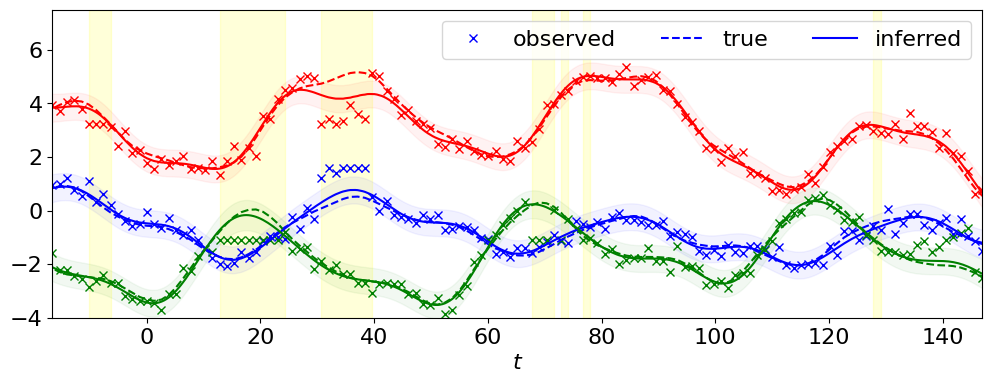

In [30]:
eval_model(model, t, R, jnp.array(censoring_thre), y, y_diffused, t_plot, R_plot, jnp.array(censoring_thre_plot), y_plot)

Iter [9999/10000]: 100%|██████████| 10000/10000 [1:00:20<00:00,  2.76it/s, loss=376.47759190012664]


optimisation time: 3620.79 secs


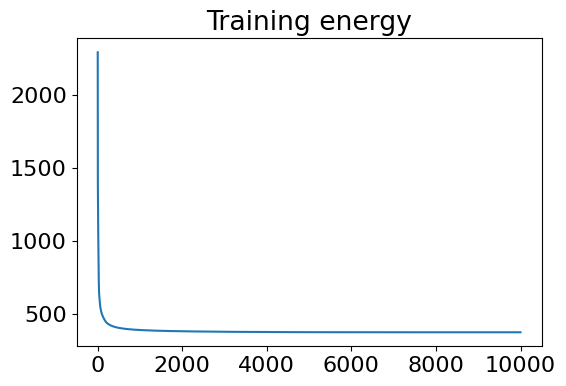

In [31]:
# model definition
# kern_time = bayesnewton.kernels.Matern32(variance=var_f, lengthscale=len_time)
kern_time0 = bayesnewton.kernels.Matern32(variance=var_f, lengthscale=len_time)
kern_time1 = bayesnewton.kernels.Periodic(variance=var_f, lengthscale=len_time, period=period, order=3)
kern_time = bayesnewton.kernels.Sum([kern_time0, kern_time1])
#kern_time = bayesnewton.kernels.Periodic(variance=var_f, lengthscale=len_time, period=period, order=3)
kern_space0 = bayesnewton.kernels.Matern32(variance=var_f, lengthscale=len_space)
kern_space1 = bayesnewton.kernels.Matern32(variance=var_f, lengthscale=len_space)
kern_space = bayesnewton.kernels.Separable([kern_space0, kern_space1])

kern = bayesnewton.kernels.SpatioTemporalKernel(temporal_kernel=kern_time,
                                                spatial_kernel=kern_space,
                                                z=z,
                                                sparse=sparse,
                                                opt_z=opt_z,
                                                conditional='DTC')

lik = MyDiffusedCensoredGaussianD(X_diffusion=X_diffusion, 
                                diffusion_steps=2,
                                diffusion_lengthscale=.1,
                                diffusion_variance=1.,
                                sink_prob=0.2,
                                fix_diffusion=False,
                                variance=lik_variance)
#lik = MyGaussian(variance=lik_variance)
#model = bayesnewton.models.MarkovVariationalGP(kernel=kern, likelihood=lik, X=t, R=R, Y=np.concatenate([y_diffused, censoring_thre], axis=2))
model = bayesnewton.models.MarkovVariationalGP(kernel=kern, likelihood=lik, X=t, R=R, Y=y_diffused, extra=jnp.array(censoring_thre))
#model = bayesnewton.models.MarkovVariationalGP(kernel=kern, likelihood=lik, X=t, R=R, Y=y_diffused)

model = train_model(model, iters = 10000) # this works better than the fancy LRs below
#model = train_model(model, iters=1000, lr_newton=0.1, lr_adam=0.01) # in this case, this LR made things worse!!

[trainset] nlpd (diff): 0.050	nlpd (true): -0.005	rmse (true): 0.255	r2 (true): 0.931	rmse (func): 0.174
[testset] 			nlpd (true): 0.060	rmse (true): 0.286	r2 (true): 0.918	rmse (func): 0.199


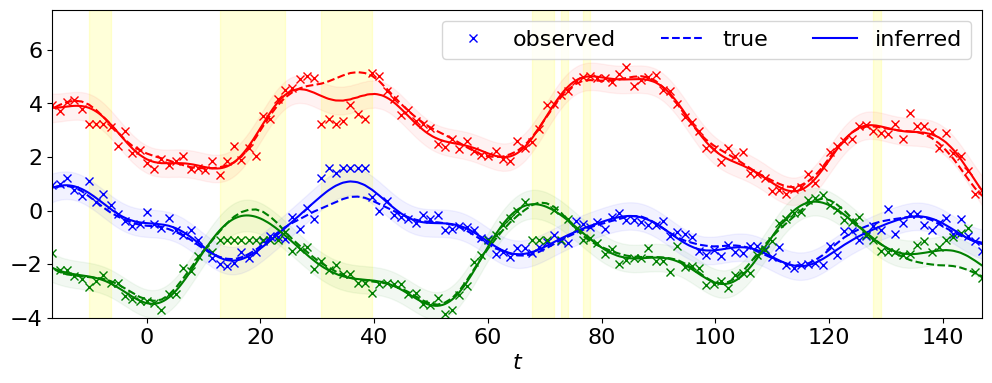

In [32]:
eval_model(model, t, R, jnp.array(censoring_thre), y, y_diffused, t_plot, R_plot, jnp.array(censoring_thre_plot), y_plot)